## For imports to work in jupyter notebook

In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

# Dataset name

In [2]:
dataset = os.path.basename(os.getcwd())

# Imports

In [3]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
from Data import PREPROCESS_FUNCTIONS

# Data import

In [4]:
raw_data = pd.read_csv(os.path.join(os.getcwd(), f"{dataset}.data"))
raw_data.head()

,id,Clump Thickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Data analysys

In [5]:
print(f"shape: {raw_data.shape}")
raw_data.info()

shape: (699, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Cell Size                    699 non-null    int64 
 3   Cell Shape                   699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


Mamy do czynienia ze zbiorem 699 rekordów, z 9 atrybutami dyskretnymi w skali 1-10. Atrybut Bare Nuclei jest typu object, co oznacza, że zawiera on wartości nieprawidłowe. Wartości te zostaną usunięte w dalszej części analizy.

In [6]:
# show records with missing values where Bare Nuclei is ?
print(f"Number of records with missing values: {raw_data[raw_data['Bare Nuclei'] == '?'].shape[0]}")
raw_data[raw_data["Bare Nuclei"] == "?"]

Number of records with missing values: 16


,id,Clump Thickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


Aż 16 rekordów z brakującymi wartościami, muszą one zostać usunięte

In [8]:
raw_data.duplicated().sum()

8

Mamy 8 rekordów zduplokowanych. Nie jest to dużo, ususniemy je.

In [9]:
#delete duplicated records
raw_data.drop_duplicates(inplace=True)

## Dysproporcje w klasach

<Axes: title={'center': 'Class distribution'}, xlabel='Class', ylabel='Count'>

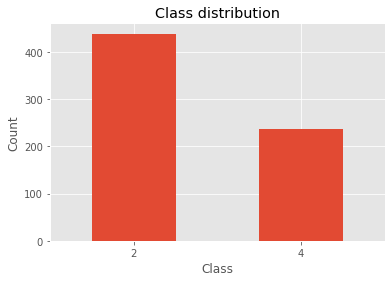

In [10]:
# Plot the distribution of the class attribute
raw_data['Class'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count', rot=0)

In [11]:
recursive_events_percentage = raw_data.value_counts('Class')[4] / \
    (raw_data.value_counts('Class')[2] + raw_data.value_counts('Class')[4])
print(f'recursive events percentage: {recursive_events_percentage}')

recursive events percentage: 0.3496296296296296


Widzimy znacznie lepsze rozłożenie klas niż w przypadku zbioru danych 'breast-cancer'. W dalszym ciągu, jest dwa razy więcej pacjentów z klasą 0 (łagodny rak) niż z klasą 1 (rak złośliwy), ale ilość danych rekompensuje nam tę dysproporcję. W dalszym ciągu, przy uczeniu modeli dalej może być wymagane użycie samplera, ale tę decyzję projektową zostawimy na później - przy okazji procesu analizy modeli.

## Removing missing values

In [12]:
attributes_missing = ['Bare Nuclei']
for attribute in attributes_missing:
    raw_data[attribute] = raw_data[attribute].replace(
        '?', raw_data[attribute].value_counts().idxmax())
    
data_without_missing_values = raw_data.drop(["id"], axis=1)

In [13]:
for name, series in data_without_missing_values.iteritems():
    print(name, series.unique())

Clump Thickness [ 5  3  6  4  8  1  2  7 10  9]
Cell Size [ 1  4  8 10  2  3  7  5  6  9]
Cell Shape [ 1  4  8 10  2  3  5  6  7  9]
Marginal Adhesion [ 1  5  3  8 10  4  6  2  9  7]
Single Epithelial Cell Size [ 2  7  3  1  6  4  5  8 10  9]
Bare Nuclei [ 1 10  2  4  3  9  7  5  8  6]
Bland Chromatin [ 3  9  1  2  4  5  7  8  6 10]
Normal Nucleoli [ 1  2  7  4  5  3 10  6  9  8]
Mitoses [ 1  5  4  2  3  7 10  8  6]
Class [2 4]


W procesie preprocessingu pozbyliśmy się brakujących wartości. Możemy przejść do dalszej analizy zbioru danych.

## Wizualizacja częstości występowania atrybutów

C:\Users\User\AppData\Local\Temp/ipykernel_35996/3574025566.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=40.0)


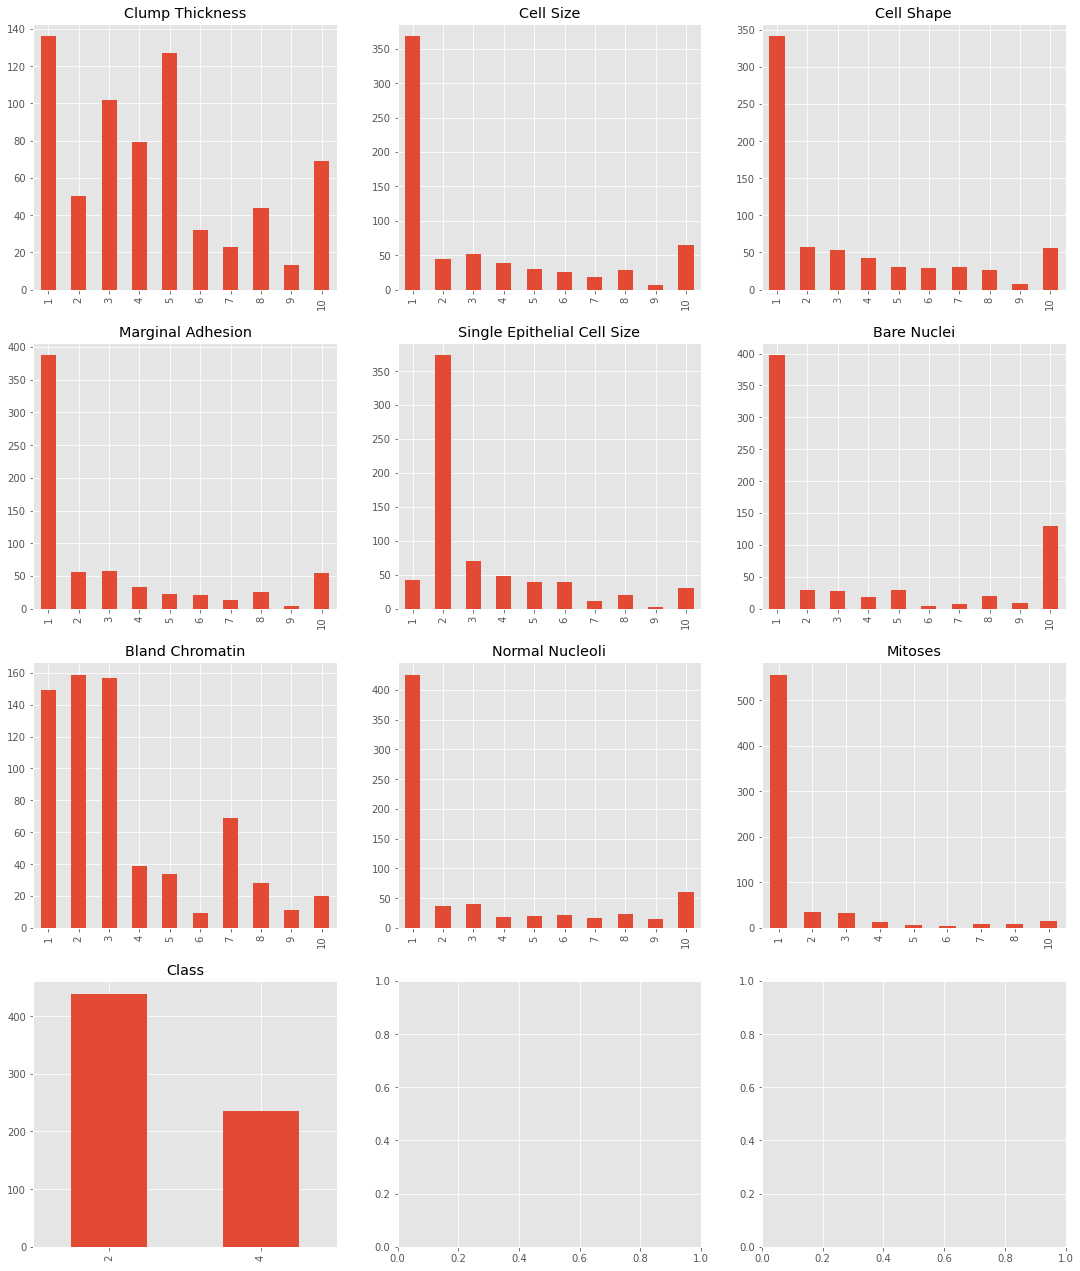

In [14]:
from math import ceil
from copy import deepcopy

fig, axes = plt.subplots(ceil(len(data_without_missing_values.columns)/3), 3)
fig.tight_layout(pad=40.0)
fig.set_size_inches(18.5, 22.5)

row = 0
col = 0
for name, values in deepcopy(data_without_missing_values).iteritems():
  axes[row, col].set_title(name)
  values.value_counts().sort_index(ascending=True).plot(kind='bar', ax=axes[row, col])

  col += 1
  if col %3 == 0:
    row += 1
    col = 0

W przypadku wielu atrybutów jest zauważalna znaczna dysproporcja pomiędzy występującymi wartościami. W przypadku przeważającej części atrybutów (Normal Nucleoi, Mitosis, Marginal adhesion, Bare nuclei, Cell size, Cell Shape), 90% wszystkich wartości stanowi 1. Może to stanowić problemy przy uczeniu modeli i wymaga dodania normalizacji do preprocessingu.

## Preprocessed data

In [15]:
preprocessed_data = PREPROCESS_FUNCTIONS[dataset](raw_data=raw_data)
preprocessed_data.head()

,Clump Thickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,class
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0,0
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0,0
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0,0
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0,0
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0,0


In [16]:
for name, series in preprocessed_data.iteritems():
    print(name, series.unique())

Clump Thickness [0.44444444 0.22222222 0.55555556 0.33333333 0.77777778 0.
 0.11111111 0.66666667 1.         0.88888889]
Cell Size [0.         0.33333333 0.77777778 1.         0.11111111 0.22222222
 0.66666667 0.44444444 0.55555556 0.88888889]
Cell Shape [0.         0.33333333 0.77777778 1.         0.11111111 0.22222222
 0.44444444 0.55555556 0.66666667 0.88888889]
Marginal Adhesion [0.         0.44444444 0.22222222 0.77777778 1.         0.33333333
 0.55555556 0.11111111 0.88888889 0.66666667]
Single Epithelial Cell Size [0.11111111 0.66666667 0.22222222 0.         0.55555556 0.33333333
 0.44444444 0.77777778 1.         0.88888889]
Bare Nuclei [0.         1.         0.11111111 0.33333333 0.22222222 0.88888889
 0.66666667 0.44444444 0.77777778 0.55555556]
Bland Chromatin [0.22222222 0.88888889 0.         0.11111111 0.33333333 0.44444444
 0.66666667 0.77777778 0.55555556 1.        ]
Normal Nucleoli [0.         0.11111111 0.66666667 0.33333333 0.44444444 0.22222222
 1.         0.55555556 

W procesie obróbki danych wszystkie atrybuty zostały znormalizowane, brakujące wartości uzupełnione a atrybuty klasowe przerzutowane na odpowiadające naszemu problemowi. Możemy przejść do analizy danych przeprocesowanych.

### Attributes Correlations

<Axes: >

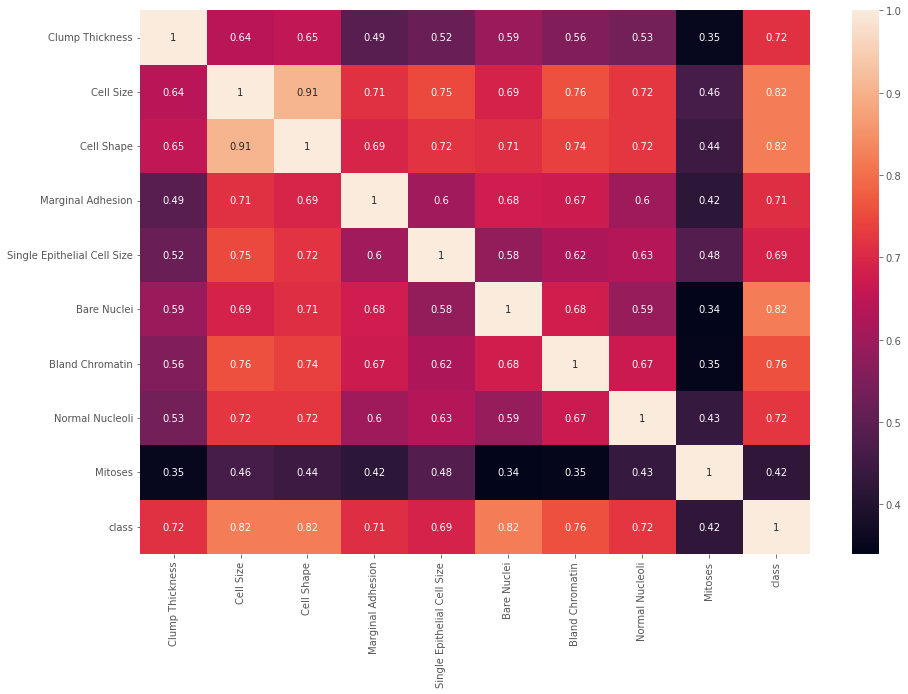

In [17]:
CorrMat = preprocessed_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMat, annot=True)
# plot 

Widzimy silną zależność pomiędzy atrybutami cell shape i cell size. Jest to raczej logiczne - rozmiar komórki jest zależny od jej kształtu.
Najsilniej skorelowane z atrybutem klasy są Cell Size, Cell Shape i Bare Nuclei. Złośliwość nowotworu jest zwykle związana z rozmiarem komórki, co uzasadnia korelację Cell Size i Cell shape z klasą. Bare nuclei odnosi się do jądra nieotoczonego cytoplazmą (resztą komórki) - zjawisko to zwykle wiąże się z niezłośliwością nowotworu, co uzasadnia tę korelację. Najsłabiej skorelowany z atrybutem klasy jest atrybut Mitoses - liczba komórek dzielących się, widocznych w histopatologii barwionej hematoksyliną i eozyną (H&E). Zwykle jest to dobry wyznacznik agresywności guza, ale w przypadku naszego zbioru danych nie stanowi on aż tak dobrego wyznacznika jak pozostałe atrybuty.

Przeanalizujmy dokładniej zależność Rozmiaru komórki i jej kształtu oraz odsłoniętego jądra komórkowego z klasą.

## CELL SHAPE, CELL SIZE

<Axes: xlabel='Cell Size', ylabel='Cell Shape'>

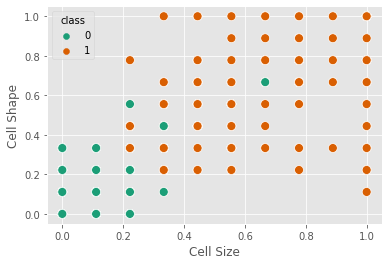

In [18]:
sns.scatterplot(x="Cell Size", y="Cell Shape", hue="class", data=preprocessed_data, palette="Dark2", s=80)

Na powyższym wykresie widzimy prawie liniową zależnośc pomiędzy tymi dwoma atrybutami a atrybutem reprezentującym klasę. Należy jednak pamiętać, że na wykresie punkty reprezentujące klasę mogą się na siebie nakładać i w rzeczywistości rozdzielenie klas za pomocą jedynie tych dwóch atrybutów może być ciężkie lub niemożliwe.

## CELL SHAPE, BARE NUCLEI

<Axes: xlabel='Cell Shape', ylabel='Bare Nuclei'>

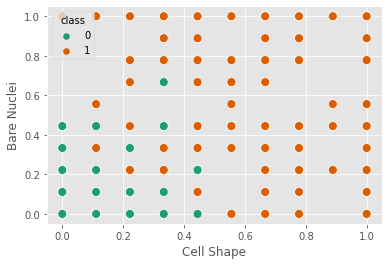

In [19]:
sns.scatterplot(x="Cell Shape", y="Bare Nuclei", hue="class", data=preprocessed_data, palette="Dark2", s=80)

Tutaj również daje się wysnuć te same wnioski, co powyżej - w przypadku zależności między cell size z cell shape.

## CELL SIZE, BARE NUCLEI

<Axes: xlabel='Cell Size', ylabel='Bare Nuclei'>

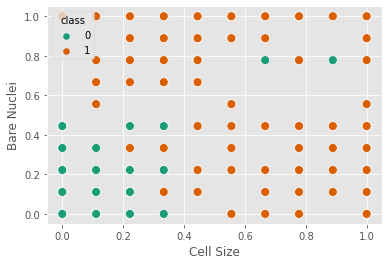

In [20]:
sns.scatterplot(x="Cell Size", y="Bare Nuclei", hue="class", data=preprocessed_data, palette="Dark2", s=80)

Tutaj również daje się wysnuć te same wnioski, co powyżej - w przypadku zależności między cell size z cell shape.

Przeanalizujmy inne zależności między atrybutami.

<Figure size 432x288 with 0 Axes>

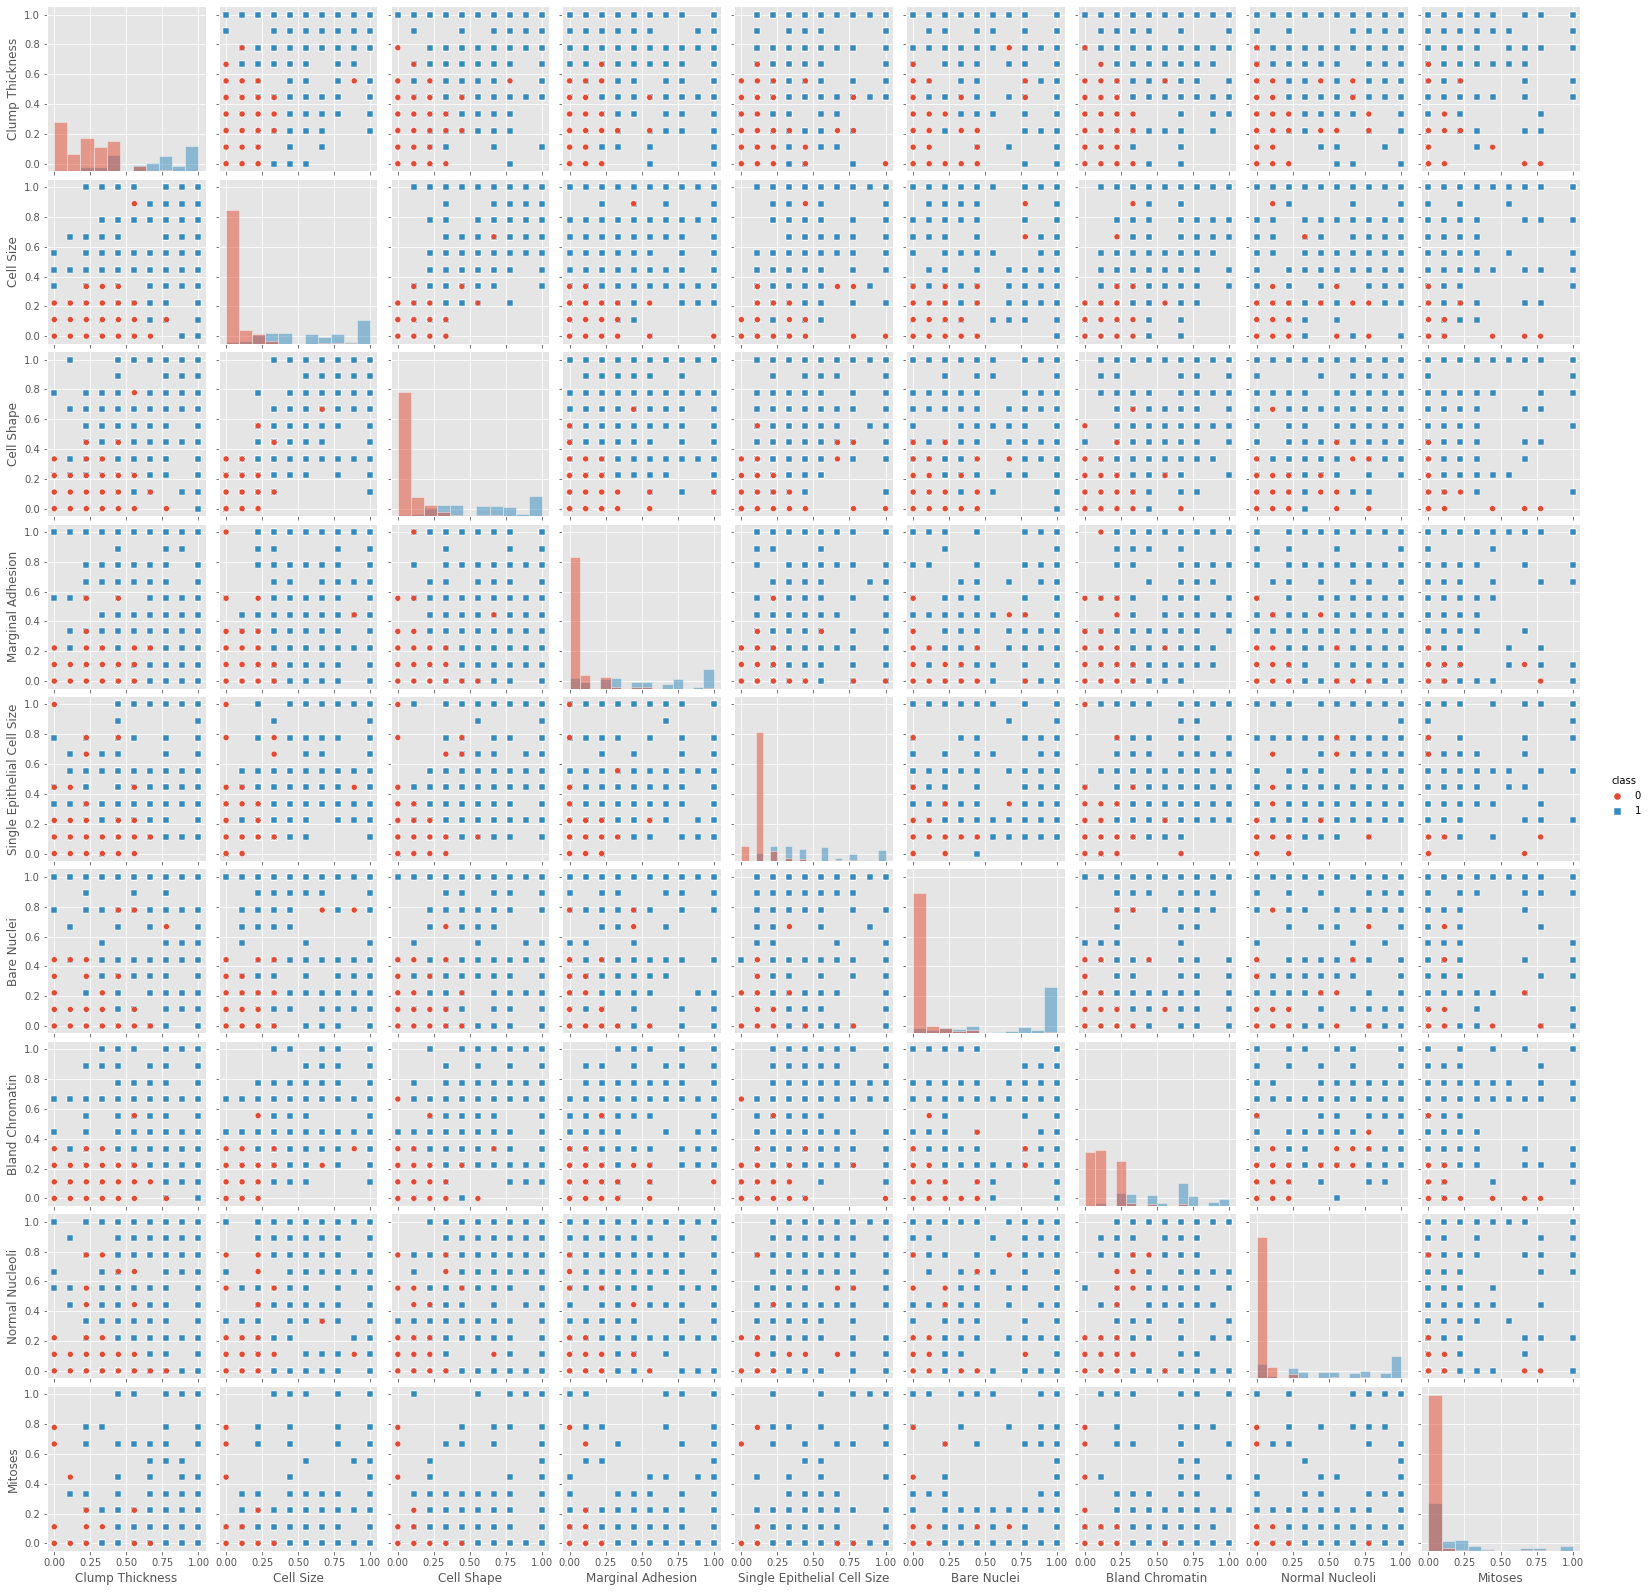

In [21]:
plt.figure()
cols_to_plot = preprocessed_data.columns
sns.pairplot(preprocessed_data[cols_to_plot], hue ="class", markers=["o", "s"], diag_kind="hist")
plt.show()

W większości przypadków widać wyraźny podział między klasami na wykresach. Jest to dobra wiadomość, spodziewamy się, że modele będą działały dobrze a osiągane przez nie wyniki będą satysfakcjonujące.

## Porównanie liczności klas z wartościami silnie skorelowanych z nią atrybutów

C:\Users\User\AppData\Local\Temp/ipykernel_35996/785794906.py:2: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=40.0)


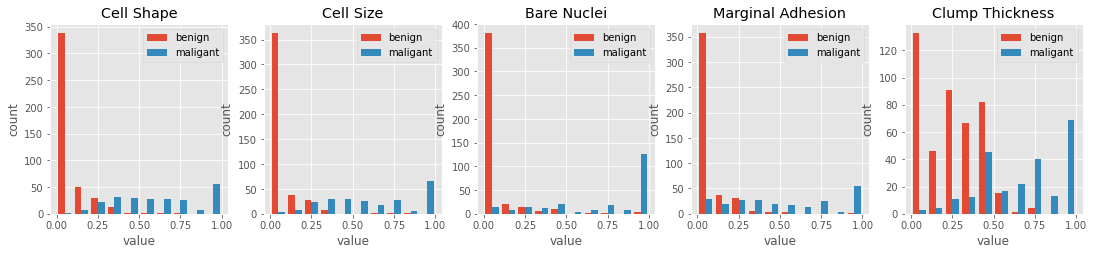

In [22]:
fig, axes = plt.subplots(1, 5)
fig.tight_layout(pad=40.0)
fig.set_size_inches(18.5, 3.5)

cols_to_plot = ["Cell Shape", "Cell Size", "Bare Nuclei", "Marginal Adhesion", "Clump Thickness"]
class_0 = preprocessed_data[preprocessed_data['class'] == 0]
class_1 = preprocessed_data[preprocessed_data['class'] == 1]

for i, col in enumerate(cols_to_plot):
  axes[i].hist(x=[class_0[col], class_1[col]])
  axes[i].set_title(col)
  axes[i].set(xlabel='value', ylabel='count')
  axes[i].legend(('benign', 'maligant') )

plt.show()

Na powyższym wykresie jeszcze dokładniej widoczne są granice między wartościami atrybutów a przyporządkowaną klasą.

# Wnioski z analizy

* Ten zbiór danych wydaje się być znacznie lepszy niż breast_cancer z wielu powodów:
( liczność danych,
  mniej powtarzających się wierszy,
  mniej wartości brakujących,
  Wszystkie atrybuty da się znormalizować,
  Zależności między atrybutami a klasą są silne a granice podziału wyraźne)
* Najsilniej skorelowane z atrybutem klasy są atrybuty Cell Size, Cell Shape oraz Bare Nuclei
* W zbiorze danych dalej występują dysproporcje, ale przez liczność danych nie powinno stanowić to aż tak dużego problemu jak w przypadku zbioru danych breast_cancer